In [ ]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


# Setting seed for reproducability
np.random.seed(1234)  
PYTHONHASHSEED = 0
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
%matplotlib inline

In [ ]:
train_2= pd.read_csv("/content/drive/MyDrive/Capstone/CMAPSSData/train_FD002.txt" ,sep=" ",header=None)
train_2.drop(columns=[26,27],inplace=True)
train_2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,8.00,194.64,2222.65,8341.91,1.02,42.02,183.06,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,5.71,138.51,2211.57,8303.96,1.02,42.20,130.42,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,9.02,175.71,1915.11,8001.42,0.94,36.69,164.22,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,5.71,138.46,2211.58,8303.96,1.02,41.96,130.72,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,9.03,175.05,1915.10,7993.23,0.94,36.89,164.31,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286


In [ ]:
test_2= pd.read_csv("/content/drive/MyDrive/Capstone/CMAPSSData/test_FD002.txt",sep=" ",header=None)
test_2.head()
test_2.drop(columns=[26,27],inplace=True)
test_2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
0,1,1,9.9987,0.2502,100.0,489.05,605.03,1497.17,1304.99,10.52,15.49,394.54,2318.96,8763.80,1.26,45.61,371.69,2388.18,8114.10,8.6476,0.03,369,2319,100.00,28.42,17.1551
1,1,2,20.0026,0.7000,100.0,491.19,607.82,1481.20,1246.11,9.35,13.66,334.36,2323.95,8713.21,1.08,44.26,315.32,2388.12,8053.06,9.2405,0.02,364,2324,100.00,24.29,14.8039
2,1,3,35.0045,0.8400,100.0,449.44,556.00,1359.08,1128.36,5.48,8.00,193.55,2222.67,8340.20,1.02,41.80,183.04,2387.75,8053.04,9.3472,0.02,333,2223,100.00,14.98,8.9125
3,1,4,42.0066,0.8410,100.0,445.00,550.17,1349.69,1127.89,3.91,5.71,138.74,2211.58,8313.85,1.02,42.21,130.40,2387.72,8066.90,9.3961,0.02,332,2212,100.00,10.35,6.4181
4,1,5,24.9985,0.6213,60.0,462.54,536.72,1253.18,1050.69,7.05,9.03,175.75,1915.10,7997.13,0.94,36.76,164.56,2028.05,7865.66,10.8682,0.02,305,1915,84.93,14.31,8.5740


In [ ]:
rul_2= pd.read_csv("/content/drive/MyDrive/Capstone/CMAPSSData/RUL_FD002.txt",sep=" ",header=None)
rul_2.head()
rul_2.drop(columns=[1],inplace=True)
rul_2.head()

,0
0,18
1,79
2,106
3,110
4,15


In [ ]:
columns = ['unit_number','time_in_cycles','setting_1','setting_2','TRA','T2','T24','T30','T50','P2','P15','P30','Nf',
           'Nc','epr','Ps30','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32' ]
train_2.columns = columns
test_2.columns = columns

In [ ]:
train_2.head()

,unit_number,time_in_cycles,setting_1,setting_2,TRA,T2,T24,T30,T50,P2,P15,P30,Nf,Nc,epr,Ps30,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,8.00,194.64,2222.65,8341.91,1.02,42.02,183.06,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,5.71,138.51,2211.57,8303.96,1.02,42.20,130.42,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,9.02,175.71,1915.11,8001.42,0.94,36.69,164.22,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,5.71,138.46,2211.58,8303.96,1.02,41.96,130.72,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,9.03,175.05,1915.10,7993.23,0.94,36.89,164.31,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286


In [ ]:
test_2.head()

,unit_number,time_in_cycles,setting_1,setting_2,TRA,T2,T24,T30,T50,P2,P15,P30,Nf,Nc,epr,Ps30,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32
0,1,1,9.9987,0.2502,100.0,489.05,605.03,1497.17,1304.99,10.52,15.49,394.54,2318.96,8763.80,1.26,45.61,371.69,2388.18,8114.10,8.6476,0.03,369,2319,100.00,28.42,17.1551
1,1,2,20.0026,0.7000,100.0,491.19,607.82,1481.20,1246.11,9.35,13.66,334.36,2323.95,8713.21,1.08,44.26,315.32,2388.12,8053.06,9.2405,0.02,364,2324,100.00,24.29,14.8039
2,1,3,35.0045,0.8400,100.0,449.44,556.00,1359.08,1128.36,5.48,8.00,193.55,2222.67,8340.20,1.02,41.80,183.04,2387.75,8053.04,9.3472,0.02,333,2223,100.00,14.98,8.9125
3,1,4,42.0066,0.8410,100.0,445.00,550.17,1349.69,1127.89,3.91,5.71,138.74,2211.58,8313.85,1.02,42.21,130.40,2387.72,8066.90,9.3961,0.02,332,2212,100.00,10.35,6.4181
4,1,5,24.9985,0.6213,60.0,462.54,536.72,1253.18,1050.69,7.05,9.03,175.75,1915.10,7997.13,0.94,36.76,164.56,2028.05,7865.66,10.8682,0.02,305,1915,84.93,14.31,8.5740


In [ ]:
description = train_2.describe()
description.loc['std']

unit_number        74.463862
time_in_cycles     69.180569
setting_1          14.747376
setting_2           0.310016
TRA                14.237735
T2                 26.389707
T24                37.289399
T30               105.946341
T50               119.123428
P2                  3.613839
P15                 5.431802
P30               146.005306
Nf                145.209816
Nc                335.812013
epr                 0.127469
Ps30                3.232372
phi               137.659507
NRf               128.068271
NRc                84.837950
BPR                 0.749335
farB                0.004711
htBleed            27.754515
Nf_dmd            145.327980
PCNfR_dmd           5.364067
W31                 9.869331
W32                 5.921615
Name: std, dtype: float64

In [ ]:
#delete columns with constant values that do not carry information about the state of the unit
# train_2.drop(columns=['Nf_dmd','PCNfR_dmd','P2','T2','TRA','farB','epr'],inplace=True)

In [ ]:
#Adding RUL column 
#function for preparing training data and forming a RUL column with information about the remaining
# before breaking cycles
def prepare_train_data(data, factor = 0):
    df = data.copy()
    fd_RUL = df.groupby('unit_number')['time_in_cycles'].max().reset_index()
    fd_RUL = pd.DataFrame(fd_RUL)
    fd_RUL.columns = ['unit_number','max']
    df = df.merge(fd_RUL, on=['unit_number'], how='left')
    df['RUL'] = df['max'] - df['time_in_cycles']
    df.drop(columns=['max'],inplace = True)
    return df[df['time_in_cycles'] > factor]

In [ ]:
train_2 = prepare_train_data(train_2)

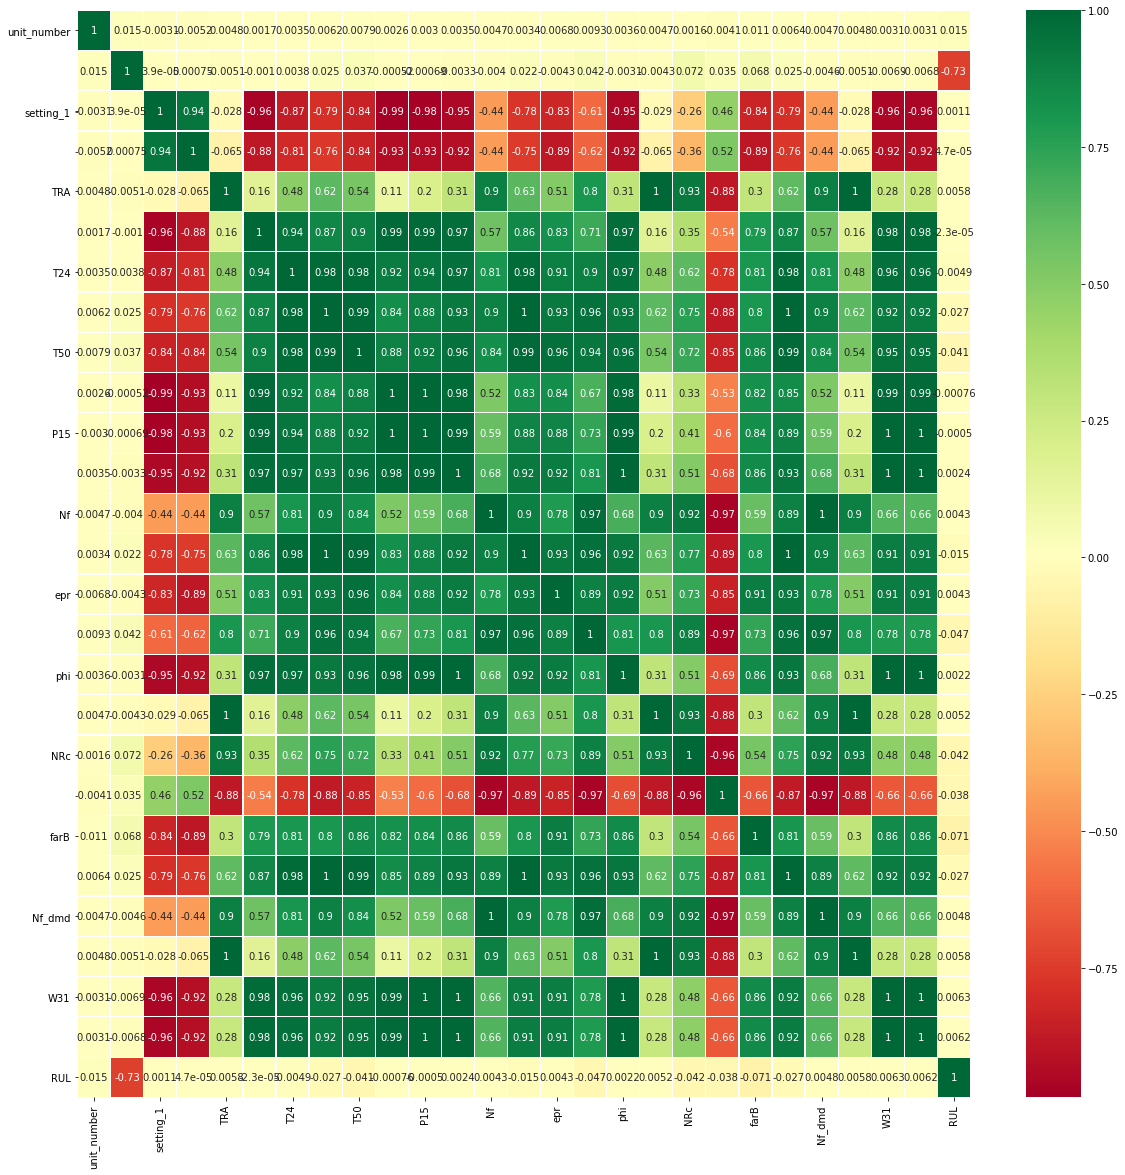

In [ ]:
sns.heatmap(train_2.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(20,20)
plt.show()

In [ ]:
# generate label columns for training data
w1 = 30
w0 = 15
train_2['label1'] = np.where(train_2['RUL'] <= w1, 1, 0 )
train_2['label2'] = train_2['label1']
train_2.loc[train_2['RUL'] <= w0, 'label2'] = 2
train_2.head()

,unit_number,time_in_cycles,setting_1,setting_2,TRA,T2,T24,T30,T50,P2,P15,P30,Nf,Nc,epr,Ps30,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,RUL,label1,label2
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,8.00,194.64,2222.65,8341.91,1.02,42.02,183.06,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071,148,0,0
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,5.71,138.51,2211.57,8303.96,1.02,42.20,130.42,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665,147,0,0
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,9.02,175.71,1915.11,8001.42,0.94,36.69,164.22,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723,146,0,0
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,5.71,138.46,2211.58,8303.96,1.02,41.96,130.72,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701,145,0,0
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,9.03,175.05,1915.10,7993.23,0.94,36.89,164.31,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286,144,0,0


In [ ]:
# MinMax normalization
train_2['cycle_norm'] = train_2['time_in_cycles']
cols_normalize = train_2.columns.difference(['unit_number','time_in_cycles','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_2 = pd.DataFrame(min_max_scaler.fit_transform(train_2[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_2.index)
join_1 = train_2[train_2.columns.difference(cols_normalize)].join(norm_train_2)
train_2 = join_1.reindex(columns = train_2.columns)
train_2.head()

,unit_number,time_in_cycles,setting_1,setting_2,TRA,T2,T24,T30,T50,P2,P15,P30,Nf,Nc,epr,Ps30,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,RUL,label1,label2,cycle_norm
0,1,1,0.833134,0.997625,1.0,0.060269,0.181576,0.311201,0.273095,0.146592,0.144025,0.138036,0.650057,0.289692,0.243243,0.471498,0.136817,0.992394,0.476508,0.369947,0.0,0.322917,0.651163,1.0,0.156036,0.159082,148,0,0,0.000000
1,1,2,0.999767,0.998575,1.0,0.000000,0.131847,0.296600,0.245535,0.000000,0.000000,0.004081,0.626663,0.258841,0.243243,0.486156,0.003297,0.992229,0.533013,0.381407,0.0,0.281250,0.627907,1.0,0.007888,0.014562,147,0,0,0.002653
2,1,3,0.595096,0.738480,0.0,0.238089,0.016332,0.035297,0.056997,0.293184,0.208176,0.092860,0.000718,0.012893,0.027027,0.037459,0.089030,0.001157,0.039296,0.936731,0.0,0.062500,0.000000,0.0,0.133745,0.151414,146,0,0,0.005305
3,1,4,0.999993,0.999525,1.0,0.000000,0.128269,0.298795,0.246979,0.000000,0.000000,0.003962,0.626684,0.258841,0.243243,0.466612,0.004058,0.992091,0.524349,0.372400,0.0,0.270833,0.627907,1.0,0.014060,0.026144,145,0,0,0.007958
4,1,5,0.595137,0.736698,0.0,0.238089,0.014130,0.037871,0.058152,0.293184,0.208805,0.091284,0.000697,0.006235,0.027027,0.053746,0.089258,0.001075,0.030633,0.937537,0.0,0.062500,0.000000,0.0,0.135460,0.143240,144,0,0,0.010610


In [ ]:
test_2['cycle_norm'] = test_2['time_in_cycles']
norm_test_2 = pd.DataFrame(min_max_scaler.transform(test_2[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_2.index)
test_join_1 = test_2[test_2.columns.difference(cols_normalize)].join(norm_test_2)
test_2 = test_join_1.reindex(columns = test_2.columns)
test_2 = test_2.reset_index(drop=True)
test_2.head()

,unit_number,time_in_cycles,setting_1,setting_2,TRA,T2,T24,T30,T50,P2,P15,P30,Nf,Nc,epr,Ps30,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,cycle_norm
0,1,1,0.238019,0.297150,1.0,0.597937,0.637673,0.686550,0.676888,0.617180,0.615094,0.615102,0.853406,0.632664,0.891892,0.763844,0.615269,0.993662,0.632503,0.114199,1.0,0.687500,0.854123,1.0,0.625514,0.633951,0.000000
1,1,2,0.476162,0.831354,1.0,0.626985,0.663272,0.643289,0.535166,0.507937,0.500000,0.471481,0.863942,0.591537,0.405405,0.653909,0.472289,0.993496,0.487219,0.331283,0.0,0.635417,0.864693,1.0,0.483882,0.500205,0.002653
2,1,3,0.833282,0.997625,1.0,0.060269,0.187815,0.312475,0.251745,0.146592,0.144025,0.135435,0.650099,0.288302,0.243243,0.453583,0.136766,0.992477,0.487171,0.370350,0.0,0.312500,0.651163,1.0,0.164609,0.165078,0.005305
3,1,4,0.999967,0.998812,1.0,0.000000,0.134324,0.287038,0.250614,0.000000,0.000000,0.004630,0.626684,0.266881,0.243243,0.486971,0.003247,0.992394,0.520160,0.388254,0.0,0.302083,0.627907,1.0,0.005830,0.023186,0.007958
4,1,5,0.595089,0.737886,0.0,0.238089,0.010918,0.025599,0.064796,0.293184,0.208805,0.092955,0.000697,0.009406,0.027027,0.043160,0.089892,0.001213,0.041177,0.927248,0.0,0.020833,0.000000,0.0,0.141632,0.145822,0.010610


In [ ]:
# generate column max for test data
rul = pd.DataFrame(test_2.groupby('unit_number')['time_in_cycles'].max()).reset_index()
rul.columns = ['unit_number', 'max']
rul_2.columns = ['more']
rul_2['unit_number'] = rul_2.index + 1
rul_2['max'] = rul['max'] + rul_2['more']
rul_2.drop('more', axis=1, inplace=True)

In [ ]:
# generate RUL for test data
test_2 = test_2.merge(rul_2, on=['unit_number'], how='left')
test_2['RUL'] = test_2['max'] - test_2['time_in_cycles']
test_2.drop('max', axis=1, inplace=True)
test_2.head()

,unit_number,time_in_cycles,setting_1,setting_2,TRA,T2,T24,T30,T50,P2,P15,P30,Nf,Nc,epr,Ps30,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,cycle_norm,RUL
0,1,1,0.238019,0.297150,1.0,0.597937,0.637673,0.686550,0.676888,0.617180,0.615094,0.615102,0.853406,0.632664,0.891892,0.763844,0.615269,0.993662,0.632503,0.114199,1.0,0.687500,0.854123,1.0,0.625514,0.633951,0.000000,275
1,1,2,0.476162,0.831354,1.0,0.626985,0.663272,0.643289,0.535166,0.507937,0.500000,0.471481,0.863942,0.591537,0.405405,0.653909,0.472289,0.993496,0.487219,0.331283,0.0,0.635417,0.864693,1.0,0.483882,0.500205,0.002653,274
2,1,3,0.833282,0.997625,1.0,0.060269,0.187815,0.312475,0.251745,0.146592,0.144025,0.135435,0.650099,0.288302,0.243243,0.453583,0.136766,0.992477,0.487171,0.370350,0.0,0.312500,0.651163,1.0,0.164609,0.165078,0.005305,273
3,1,4,0.999967,0.998812,1.0,0.000000,0.134324,0.287038,0.250614,0.000000,0.000000,0.004630,0.626684,0.266881,0.243243,0.486971,0.003247,0.992394,0.520160,0.388254,0.0,0.302083,0.627907,1.0,0.005830,0.023186,0.007958,272
4,1,5,0.595089,0.737886,0.0,0.238089,0.010918,0.025599,0.064796,0.293184,0.208805,0.092955,0.000697,0.009406,0.027027,0.043160,0.089892,0.001213,0.041177,0.927248,0.0,0.020833,0.000000,0.0,0.141632,0.145822,0.010610,271


In [ ]:
# generate label columns w0 and w1 for test data
test_2['label1'] = np.where(test_2['RUL'] <= w1, 1, 0 )
test_2['label2'] = test_2['label1']
test_2.loc[test_2['RUL'] <= w0, 'label2'] = 2
test_2.head()

,unit_number,time_in_cycles,setting_1,setting_2,TRA,T2,T24,T30,T50,P2,P15,P30,Nf,Nc,epr,Ps30,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,cycle_norm,RUL,label1,label2
0,1,1,0.238019,0.297150,1.0,0.597937,0.637673,0.686550,0.676888,0.617180,0.615094,0.615102,0.853406,0.632664,0.891892,0.763844,0.615269,0.993662,0.632503,0.114199,1.0,0.687500,0.854123,1.0,0.625514,0.633951,0.000000,275,0,0
1,1,2,0.476162,0.831354,1.0,0.626985,0.663272,0.643289,0.535166,0.507937,0.500000,0.471481,0.863942,0.591537,0.405405,0.653909,0.472289,0.993496,0.487219,0.331283,0.0,0.635417,0.864693,1.0,0.483882,0.500205,0.002653,274,0,0
2,1,3,0.833282,0.997625,1.0,0.060269,0.187815,0.312475,0.251745,0.146592,0.144025,0.135435,0.650099,0.288302,0.243243,0.453583,0.136766,0.992477,0.487171,0.370350,0.0,0.312500,0.651163,1.0,0.164609,0.165078,0.005305,273,0,0
3,1,4,0.999967,0.998812,1.0,0.000000,0.134324,0.287038,0.250614,0.000000,0.000000,0.004630,0.626684,0.266881,0.243243,0.486971,0.003247,0.992394,0.520160,0.388254,0.0,0.302083,0.627907,1.0,0.005830,0.023186,0.007958,272,0,0
4,1,5,0.595089,0.737886,0.0,0.238089,0.010918,0.025599,0.064796,0.293184,0.208805,0.092955,0.000697,0.009406,0.027027,0.043160,0.089892,0.001213,0.041177,0.927248,0.0,0.020833,0.000000,0.0,0.141632,0.145822,0.010610,271,0,0


In [ ]:
# pick a large window size of 50 cycles
sequence_length = 50

In [ ]:
test_2.columns

Index(['unit_number', 'time_in_cycles', 'setting_1', 'setting_2', 'TRA', 'T2',
       'T24', 'T30', 'T50', 'P2', 'P15', 'P30', 'Nf', 'Nc', 'epr', 'Ps30',
       'phi', 'NRf', 'NRc', 'BPR', 'farB', 'htBleed', 'Nf_dmd', 'PCNfR_dmd',
       'W31', 'W32', 'cycle_norm', 'RUL', 'label1', 'label2'],
      dtype='object')

In [ ]:
# preparing data for visualizations 
# window of 50 cycles prior to a failure point for engine id 3
engine_id3 = test_2[test_2['unit_number'] == 3]
engine_id3_50cycleWindow = engine_id3[engine_id3['RUL'] <= engine_id3['RUL'].min() + 50]
cols1 = ['TRA','T2','T24', 'T30', 'T50', 'P2', 'P15', 'P30', 'Nf', 'Nc','epr']
engine_id3_50cycleWindow1 = engine_id3_50cycleWindow[cols1]
cols2 = [ 'Ps30','phi', 'NRf', 'NRc', 'BPR', 'farB', 'htBleed', 'Nf_dmd', 'PCNfR_dmd',
       'W31', 'W32']
engine_id3_50cycleWindow2 = engine_id3_50cycleWindow[cols2]

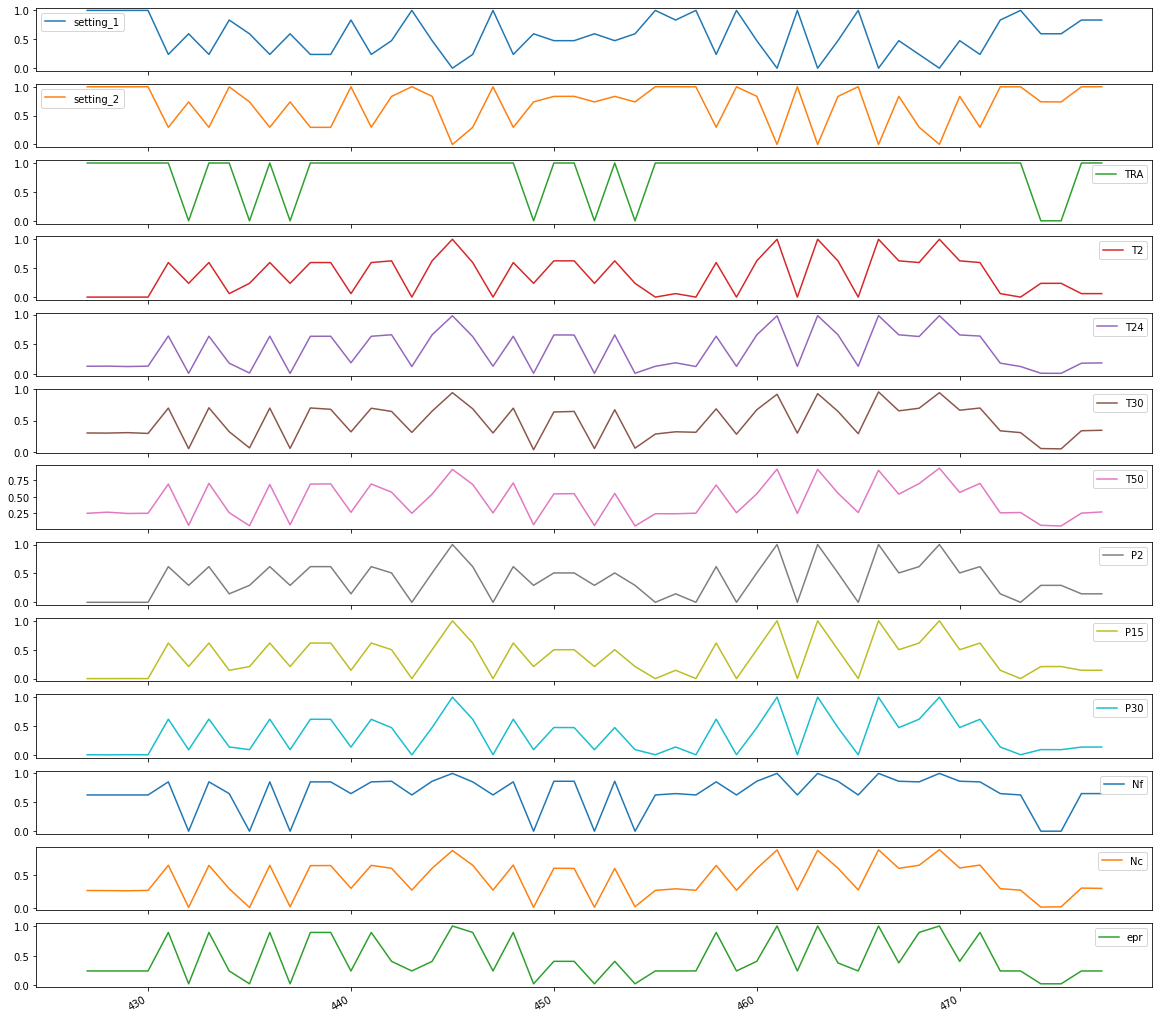

In [ ]:
# plotting sensor data for engine ID 3 prior to a failure point - sensors 1-10 
ax1 = engine_id3_50cycleWindow1.plot(subplots=True, sharex=True, figsize=(20,20))

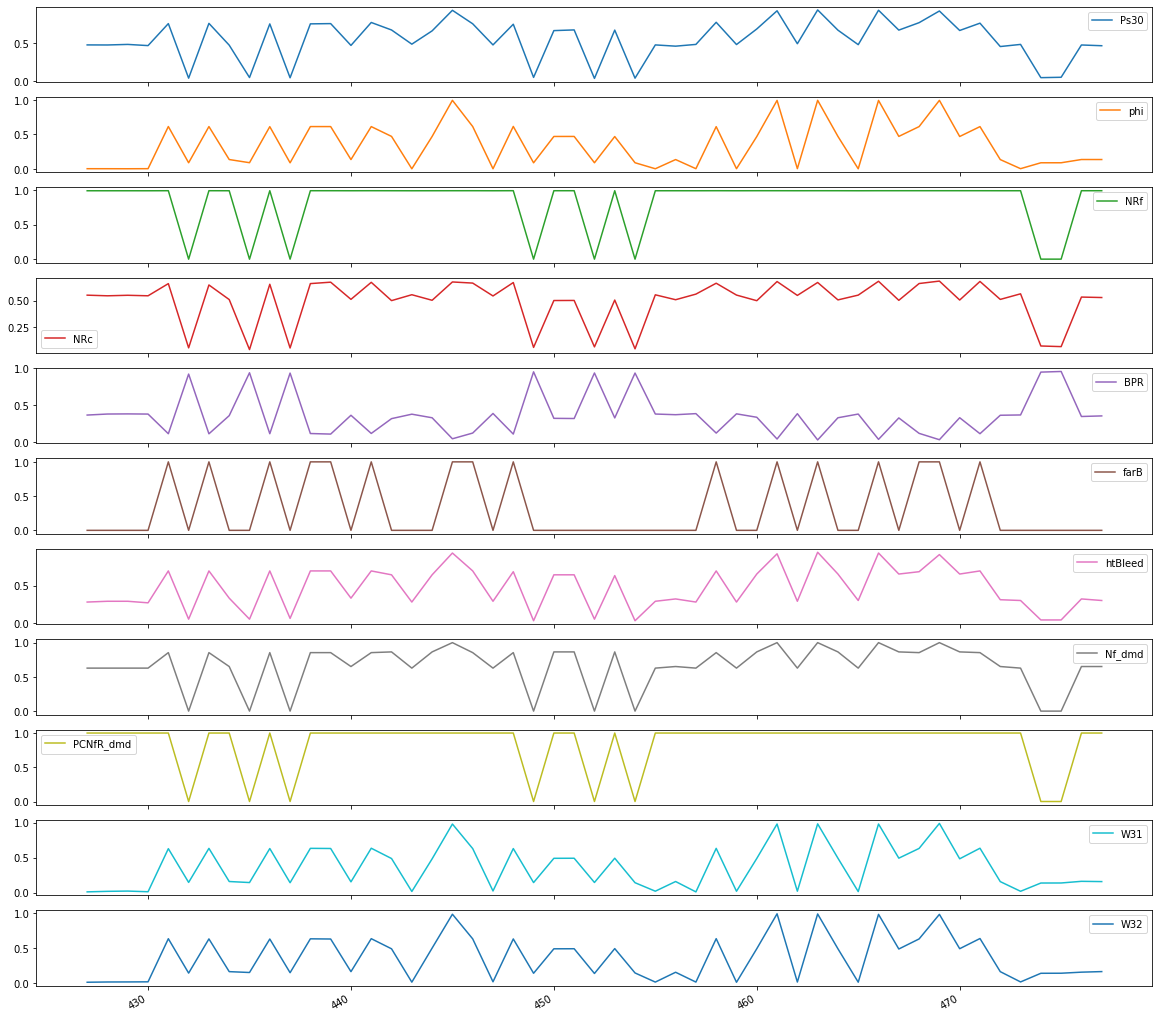

In [ ]:
# plotting sensor data for engine ID 3 prior to a failure point - sensors 11-21 
ax2 = engine_id3_50cycleWindow2.plot(subplots=True, sharex=True, figsize=(20,20))

In [ ]:
# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

In [ ]:
# 'unit_number', 'time_in_cycles', 'setting_1', 'setting_2', 'TRA', 'T2',
#        'T24', 'T30', 'T50', 'P2', 'P15', 'P30', 'Nf', 'Nc', 'epr', 'Ps30',
#        'phi', 'NRf', 'NRc', 'BPR', 'farB', 'htBleed', 'Nf_dmd', 'PCNfR_dmd',
#        'W31', 'W32', 'cycle_norm', 'RUL', 'label1', 'label2'

In [ ]:
sequence_cols = ['setting_1', 'setting_2', 'cycle_norm', 'TRA', 'T2',
       'T24', 'T30', 'T50', 'P2', 'P15', 'P30', 'Nf', 'Nc', 'epr', 'Ps30',
       'phi', 'NRf', 'NRc', 'BPR', 'farB', 'htBleed', 'Nf_dmd', 'PCNfR_dmd',
       'W31', 'W32']

In [ ]:
# generator for the sequences
seq_gen = (list(gen_sequence(train_2[train_2['unit_number']==id], sequence_length, sequence_cols)) 
           for id in train_2['unit_number'].unique())


In [ ]:
# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

(40759, 50, 25)

In [ ]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

In [ ]:
# generate labels
label_gen = [gen_labels(train_2[train_2['unit_number']==id], sequence_length, ['label1']) 
             for id in train_2['unit_number'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(40759, 1)

LSTM

In [ ]:
# build the network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

lstm_model = Sequential()

lstm_model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=300,
         return_sequences=True))
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(
          units=150,
          return_sequences=False))
lstm_model.add(Dropout(0.2))

lstm_model.add(Dense(units=nb_out, activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
print(lstm_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 300)           391200    
_________________________________________________________________
dropout (Dropout)            (None, 50, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 150)               270600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 151       
Total params: 661,951
Trainable params: 661,951
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
%%time
# fit the network
lstm_model.fit(seq_array, label_array, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')])

Epoch 1/10
194/194 [==============================] - 203s 1s/step - loss: 0.4254 - accuracy: 0.7960 - val_loss: 0.3316 - val_accuracy: 0.8513
Epoch 2/10
194/194 [==============================] - 200s 1s/step - loss: 0.2825 - accuracy: 0.8770 - val_loss: 0.2511 - val_accuracy: 0.8916
Epoch 3/10
194/194 [==============================] - 200s 1s/step - loss: 0.2533 - accuracy: 0.8956 - val_loss: 0.2363 - val_accuracy: 0.9166
Epoch 4/10
194/194 [==============================] - 200s 1s/step - loss: 0.2301 - accuracy: 0.9020 - val_loss: 0.1853 - val_accuracy: 0.9235
Epoch 5/10
194/194 [==============================] - 199s 1s/step - loss: 0.2177 - accuracy: 0.9092 - val_loss: 0.2218 - val_accuracy: 0.9308
Epoch 6/10
194/194 [==============================] - 201s 1s/step - loss: 0.2077 - accuracy: 0.9128 - val_loss: 0.1662 - val_accuracy: 0.9347
Epoch 7/10
194/194 [==============================] - 199s 1s/step - loss: 0.1943 - accuracy: 0.9172 - val_loss: 0.2943 - val_accuracy: 0.8965

In [ ]:
# training metrics
scores = lstm_model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

204/204 [==============================] - 75s 366ms/step - loss: 0.1682 - accuracy: 0.9290
Accurracy: 0.9290463328361511


204/204 [==============================] - 72s 350ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


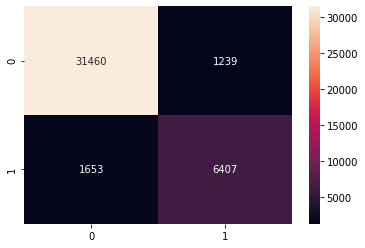

In [ ]:
# make predictions and compute confusion matrix
y_pred = lstm_model.predict_classes(seq_array,verbose=1, batch_size=200)
y_true = label_array
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

In [ ]:
# compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'precision = ', precision, '\n', 'recall = ', recall)

precision =  0.8379544860057546 
 recall =  0.7949131513647643


In [ ]:
seq_array_test_last = [test_2[test_2['unit_number']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_2['unit_number'].unique() if len(test_2[test_2['unit_number']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
seq_array_test_last.shape

(235, 50, 25)

In [ ]:
y_mask = [len(test_2[test_2['unit_number']==id]) >= sequence_length for id in test_2['unit_number'].unique()]

In [ ]:
label_array_test_last = test_2.groupby('unit_number')['label1'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
label_array_test_last.shape

(235, 1)

In [ ]:
print(seq_array_test_last.shape)
print(label_array_test_last.shape)

(235, 50, 25)
(235, 1)


In [ ]:
# test metrics
scores_test = lstm_model.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Accurracy: {}'.format(scores_test[1]))

8/8 - 1s - loss: 0.1671 - accuracy: 0.9404
Accurracy: 0.9404255151748657


Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


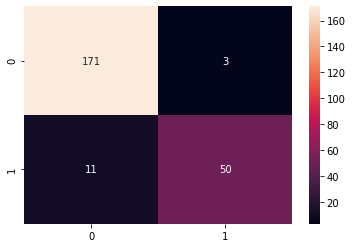

In [ ]:
# make predictions and compute confusion matrix
y_pred_test = lstm_model.predict_classes(seq_array_test_last)
y_true_test = label_array_test_last
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d')

In [ ]:
# compute precision and recall
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

Precision:  0.9433962264150944 
 Recall:  0.819672131147541 
 F1-score: 0.8771929824561403


In [ ]:
results_df = pd.DataFrame([[scores_test[1],precision_test,recall_test,f1_test]],
                         columns = ['Accuracy', 'Precision', 'Recall', 'F1-score'],
                         index = ['LSTM'])
results_df

,Accuracy,Precision,Recall,F1-score
LSTM,0.989247,1.0,0.96,0.979592


#MLP


In [ ]:
# mlp for binary classification
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
# define model
mlp_model = Sequential()
mlp_model.add(Dense(48, activation='relu', kernel_initializer='he_normal', input_shape=(nb_features * 50,)))
mlp_model.add(Dense(24, activation='relu', kernel_initializer='he_normal'))
mlp_model.add(Dense(12, activation='relu', kernel_initializer='he_normal'))
mlp_model.add(Dense(1, activation='sigmoid'))
print(mlp_model.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 48)                43248     
_________________________________________________________________
dense_13 (Dense)             (None, 24)                1176      
_________________________________________________________________
dense_14 (Dense)             (None, 12)                300       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 13        
Total params: 44,737
Trainable params: 44,737
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# compile the model
mlp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# fit the model
mlp_model.fit(seq_array.reshape(15631, 900), label_array, epochs=150, batch_size=200, validation_split=0.2, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=0, mode='auto')])

Epoch 1/150
63/63 [==============================] - 1s 8ms/step - loss: 0.4209 - accuracy: 0.7956 - val_loss: 0.2189 - val_accuracy: 0.9015
Epoch 2/150
63/63 [==============================] - 0s 4ms/step - loss: 0.1694 - accuracy: 0.9272 - val_loss: 0.1870 - val_accuracy: 0.9191
Epoch 3/150
63/63 [==============================] - 0s 4ms/step - loss: 0.1516 - accuracy: 0.9361 - val_loss: 0.1571 - val_accuracy: 0.9300
Epoch 4/150
63/63 [==============================] - 0s 5ms/step - loss: 0.1140 - accuracy: 0.9512 - val_loss: 0.1153 - val_accuracy: 0.9485
Epoch 5/150
63/63 [==============================] - 0s 5ms/step - loss: 0.0998 - accuracy: 0.9585 - val_loss: 0.0868 - val_accuracy: 0.9639
Epoch 6/150
63/63 [==============================] - 0s 4ms/step - loss: 0.0803 - accuracy: 0.9695 - val_loss: 0.0715 - val_accuracy: 0.9709
Epoch 7/150
63/63 [==============================] - 0s 4ms/step - loss: 0.0676 - accuracy: 0.9731 - val_loss: 0.0704 - val_accuracy: 0.9715
Epoch 8/150
6

79/79 [==============================] - 0s 2ms/step - loss: 0.0280 - accuracy: 0.9884
Accurracy: 0.9884204268455505
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


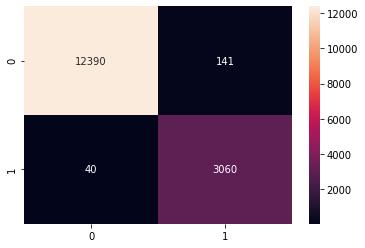

In [ ]:
# # evaluate the model
# loss, acc = model.evaluate(X_test, y_test, verbose=0)
# print('Test Accuracy: %.3f' % acc)

# training metrics
scores = mlp_model.evaluate(seq_array.reshape(15631, 900), label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

# make predictions and compute confusion matrix
y_pred = mlp_model.predict(seq_array.reshape(15631, 900)) 
y_true = label_array

# Transform Y_pred to Binary Label
y_pred = np.where(y_pred > 0.5, 1, 0)


cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt='d')

In [ ]:
# Calculate Accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = 2 * (precision * recall) / (precision + recall)
print( 'accuracy = ', accuracy,'\n', 'precision= ',precision,'\n', 'recall= ', recall,'\n','F1-score=', f1)

accuracy =  0.9884204465485253 
 precision=  0.9559512652296157 
 recall=  0.9870967741935484 
 F1-score= 0.9712744008887478


In [ ]:
results_df = pd.DataFrame([[accuracy,precision,recall,f1]],
                         columns = ['Accuracy', 'Precision', 'Recall', 'F1-score'],
                         index = ['MLP'])
results_df

,Accuracy,Precision,Recall,F1-score
MLP,0.98842,0.955951,0.987097,0.971274


In [ ]:
seq_array_test_last = [test_2[test_2['unit_number']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_2['unit_number'].unique() if len(test_2[test_2['unit_number']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
seq_array_test_last.shape

(93, 50, 18)

In [ ]:
y_mask = [len(test_2[test_2['unit_number']==id]) >= sequence_length for id in test_2['unit_number'].unique()]

In [ ]:
label_array_test_last = test_2.groupby('unit_number')['label1'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
label_array_test_last.shape

(93, 1)

In [ ]:
print(seq_array_test_last.shape)
print(label_array_test_last.shape)

(93, 50, 18)
(93, 1)


In [ ]:
# test metrics
scores_test = mlp_model.evaluate(seq_array_test_last.reshape(93, 900), label_array_test_last, verbose=2)
print('Accurracy: {}'.format(scores_test[1]))

3/3 - 0s - loss: 0.0470 - accuracy: 0.9892
Accurracy: 0.9892473220825195


Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


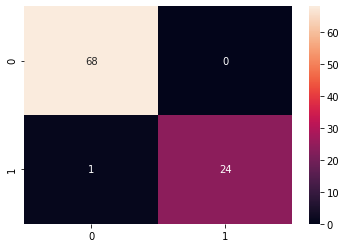

In [ ]:
# make predictions and compute confusion matrix
y_pred_test = mlp_model.predict_classes(seq_array_test_last.reshape(93, 900))
y_true_test = label_array_test_last
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d')

In [ ]:
# compute precision and recall
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

Precision:  1.0 
 Recall:  0.96 
 F1-score: 0.9795918367346939


In [ ]:
results_df = pd.DataFrame([[scores_test[1],precision_test,recall_test,f1_test]],
                         columns = ['Accuracy', 'Precision', 'Recall', 'F1-score'],
                         index = ['MLP'])
results_df

,Accuracy,Precision,Recall,F1-score
MLP,0.989247,1.0,0.96,0.979592


XGBoost

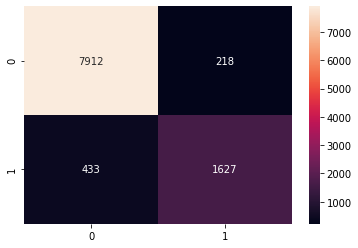

In [ ]:
## Use XGBoost 
import xgboost as xgb
import matplotlib.pyplot as plt  
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns

# Initialize Model
xgb_model = xgb.XGBClassifier(colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 16, alpha = 10, n_estimators = 16)

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(seq_array.reshape((40759,1250)), label_array, test_size=0.25, random_state=1337)

# Model Fitting on Data
xgb_model.fit(X_train, y_train)

# Get Predictions
y_pred = xgb_model.predict(X_test)

# Check Confusion Matrix
cm = confusion_matrix(y_test, y_pred)


sns.heatmap(cm, annot=True, fmt='d')

In [ ]:
# Calculate Accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = 2 * (precision * recall) / (precision + recall)
print( 'accuracy = ', accuracy,'\n', 'precision= ',precision,'\n', 'recall= ', recall,'\n','F1-score=', f1)

accuracy =  0.9361138370951914 
 precision=  0.8818428184281842 
 recall=  0.7898058252427185 
 F1-score= 0.833290653008963


In [ ]:
results_df = pd.DataFrame([[accuracy,precision,recall,f1]],
                         columns = ['Accuracy', 'Precision', 'Recall', 'F1-score'],
                         index = ['XGboost'])
results_df

,Accuracy,Precision,Recall,F1-score
XGboost,0.936114,0.881843,0.789806,0.833291
